# Introduction

Let's try to build a deterministic autoencoder for MNIST. Later on, I might try to incorporate more guidance in the encoding to encourage better clustering, but I imagine that clustering will occur naturally. 

Importantly, I'm going to try to make the latent space aggressively low dimensional -- namely, two dimensional, so we can easily inspect how the learned space divides into classes (easy in the sense that we can plot all the points and take a look; something later would be to train a classifier so that we can fully map out the latent space and not just plot codes from our training samples). 

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import time

# Data

Thanks pytorch for making this so easy to download!

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

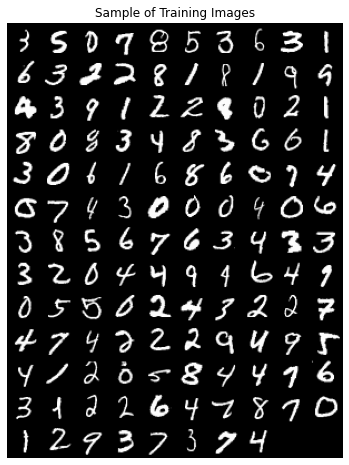

In [ ]:
def view_batch(batch):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Sample of Training Images")
    plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, nrow=10).cpu(),(1,2,0)))
    plt.show()

view_batch(next(iter(train_loader))[0])

# Network

In CMSC828W, we recently read about how overparameterized networks can achieve zero training loss. MNIST has 60000 inputs, and 10 classes, so we'd need at least 600,000 parameters to be overparameterized. That feels like overkill, so let's see how many fewer we can get away with. 

This is an almost painfully simple symmetric autoencoder built entirely of fully connected layers and ReLU activations. No reparameterization trick, no sampling, nothing.

In [ ]:
class MNIST_AE(nn.Module):
  def __init__(self, latent_dim=2, norm_to_sphere=False):
    super(MNIST_AE, self).__init__()
    self.norm_to_sphere = norm_to_sphere
    self.encoder = nn.Sequential(nn.Linear(784, 1000), nn.ReLU(),
                                 nn.Linear(1000,1000), nn.ReLU(),
                                #  nn.Linear(1000,1000), nn.ReLU(),
                                #  nn.Linear(1000,1000), nn.ReLU(),
                                 nn.Linear(1000,500), nn.ReLU(),
                                 nn.Linear(500, 100), nn.ReLU(),
                                 nn.Linear(100, latent_dim))
    self.decoder = nn.Sequential(nn.Linear(latent_dim, 100), nn.ReLU(),
                              nn.Linear(100,500), nn.ReLU(),
                              nn.Linear(500,1000), nn.ReLU(),
                              # nn.Linear(1000,1000), nn.ReLU(),
                              # nn.Linear(1000,1000), nn.ReLU(),
                              nn.Linear(1000,1000), nn.ReLU(),
                              nn.Linear(1000, 784), nn.ReLU())
  
  def forward(self, x):
    z = self.encoder(x.view(-1, 784))
    if self.norm_to_sphere:
      z = torch.div(z.T, torch.norm(z, dim=1)).T
    recon_x = self.decoder(z)
    return recon_x, z

# Training

In [ ]:
net = MNIST_AE()
net.to(device)

MNIST_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=784, bias=True)
    (9): ReLU()
  )
)

In [ ]:
def train(epochs=31, regularize=True, norm_to_sphere=False, latent_dim=2):
  model = MNIST_AE(latent_dim=latent_dim, norm_to_sphere=norm_to_sphere)
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.MSELoss()

  for epoch in range(epochs):
    losses = []
    penalties = []
    start = time.time()
    for phase in ['train', 'test']:
      if phase == 'train':
        loader = train_loader
        model.train()
      else:
        loader = test_loader
        model.eval()
    
      running_loss = 0
      running_penalty = 0
      for x, y in loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, z = model(x)
        loss = criterion(recon_x, x.view(-1, 784))
        if regularize:
          regularizer = criterion(z, torch.zeros_like(z).to(device))
          loss += regularizer
          running_penalty += regularizer.item() * x.size(0)
        if phase == 'train':
          loss.backward()
          optimizer.step()

        running_loss += loss.item() * x.size(0)
      penalties.append(running_penalty / len(loader.dataset))
      losses.append(running_loss / len(loader.dataset))

    if epoch % 5 == 0:
      print('Epoch: {:2}......Train Loss: {:.6f}......Validation Loss: {:.6f}.....Time: {:.2f}s'\
            .format(epoch, losses[0], losses[1], time.time()-start))
      if regularize:
        print('Without regularization penalty...Train Loss: {:.6f}...Validation Loss: {:.6f}'\
              .format(losses[0]-penalties[0], losses[1]-penalties[1]))
      
  return model

# Experiments

In [ ]:
trained_net = train()

Epoch:  0......Train Loss: 0.075487......Validation Loss: 0.067299.....Time: 6.95s
Without regularization penalty...Train Loss: 0.075313...Validation Loss: 0.067126
Epoch:  5......Train Loss: 0.047441......Validation Loss: 0.046957.....Time: 6.99s
Without regularization penalty...Train Loss: 0.047113...Validation Loss: 0.046622
Epoch: 10......Train Loss: 0.042563......Validation Loss: 0.042128.....Time: 7.02s
Without regularization penalty...Train Loss: 0.042220...Validation Loss: 0.041789
Epoch: 15......Train Loss: 0.040970......Validation Loss: 0.040876.....Time: 6.96s
Without regularization penalty...Train Loss: 0.040604...Validation Loss: 0.040498
Epoch: 20......Train Loss: 0.040863......Validation Loss: 0.040005.....Time: 6.95s
Without regularization penalty...Train Loss: 0.040511...Validation Loss: 0.039655
Epoch: 25......Train Loss: 0.039141......Validation Loss: 0.039638.....Time: 6.92s
Without regularization penalty...Train Loss: 0.038806...Validation Loss: 0.039314
Epoch: 30.

In [ ]:
def display_model_results(model, display=True):
  batch, labels = next(iter(train_loader))
  recon_batch, codes = model(batch.to(device))
  latent_codes = codes.detach().cpu().numpy()
  if display:
    view_batch(batch)
    view_batch(recon_batch.view(128, 1, 28, 28).detach().cpu())
  return latent_codes, labels

Here are the results of the regularized deterministic autoencoder (penalizes against norm of latent codes) with a latent dimension of two.

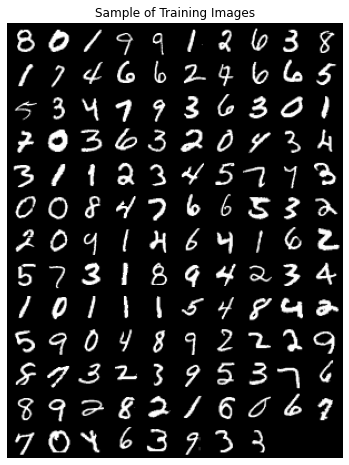

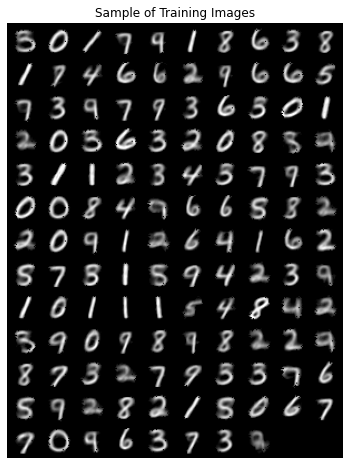

In [ ]:
codes, labels = display_model_results(trained_net)

This does surprisingly well! Not great, but ok. Let's see how the latent codes are distributed.

In [ ]:
def display_latent_codes(zs, labels):
  ''' this only really makes sense when latentdim=2 '''
  l = labels.numpy()
  for label in set(l):
    plt.scatter(zs[l == label,0], zs[l == label,1], label=label)
  plt.title('Latent Codes')
  plt.legend()
  plt.show()

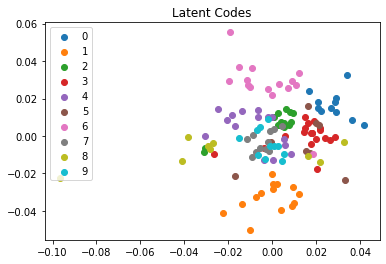

In [ ]:
display_latent_codes(codes, labels)

It seems like clusters form, but they overlap quite a bit.

Let's see what happens if we remove regularization. One thing is sure -- the latent codes are most likely going to have much larger magnitudes.

In [ ]:
nonreg_net = train(regularize=False)

Epoch:  0......Train Loss: 0.057614......Validation Loss: 0.047844.....Time: 6.80s
Epoch:  5......Train Loss: 0.040235......Validation Loss: 0.040696.....Time: 6.88s
Epoch: 10......Train Loss: 0.037614......Validation Loss: 0.037635.....Time: 6.87s
Epoch: 15......Train Loss: 0.037180......Validation Loss: 0.037310.....Time: 6.89s
Epoch: 20......Train Loss: 0.036713......Validation Loss: 0.036940.....Time: 6.81s
Epoch: 25......Train Loss: 0.036643......Validation Loss: 0.037206.....Time: 6.80s
Epoch: 30......Train Loss: 0.036982......Validation Loss: 0.037933.....Time: 6.83s


Interestingly, in equal time, we train to a significantly lower loss when we remove regularization. Let's see how our latent codes are distributed.

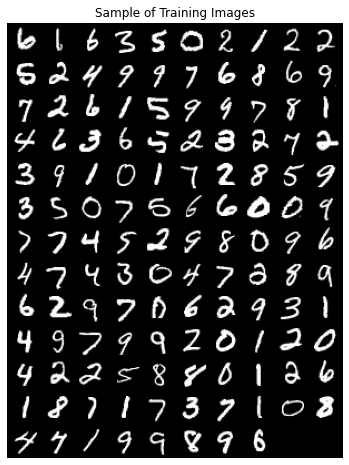

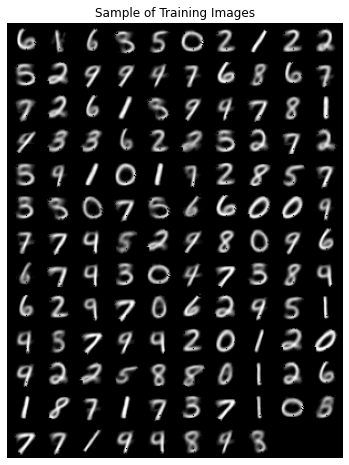

In [ ]:
nonreg_codes, labels = display_model_results(nonreg_net)

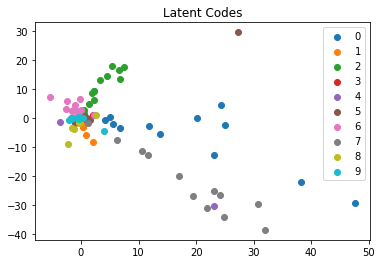

In [ ]:
display_latent_codes(nonreg_codes, labels)

## Normalizing latent codes to a unit sphere.

Some previous works normalize representation vectors to a unit-sphere. Let's see what happens if we try that. 

In [ ]:
norm_to_sphere_net = train(regularize=False, norm_to_sphere=True)

Epoch: 0......Train Loss: 0.0658906407......Validation Loss:   0.056351.....Time: 5.74s
Epoch: 5......Train Loss: 0.0533356206......Validation Loss:   0.053435.....Time: 5.88s
Epoch: 10......Train Loss: 0.0486982431......Validation Loss:   0.049062.....Time: 5.87s
Epoch: 15......Train Loss: 0.0488717790......Validation Loss:   0.048904.....Time: 5.71s
Epoch: 20......Train Loss: 0.0473569601......Validation Loss:   0.047233.....Time: 5.86s
Epoch: 25......Train Loss: 0.0476144561......Validation Loss:   0.046830.....Time: 5.70s


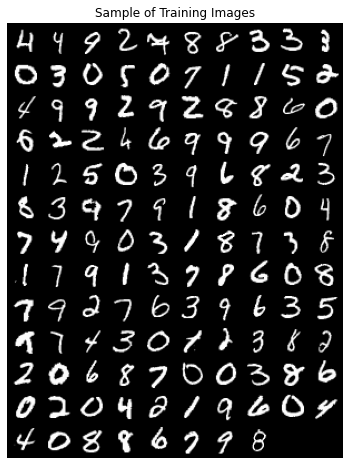

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


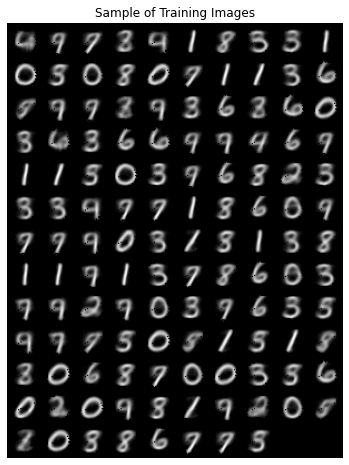

In [ ]:
norm_to_sphere_codes, labels = display_model_results(norm_to_sphere_net)

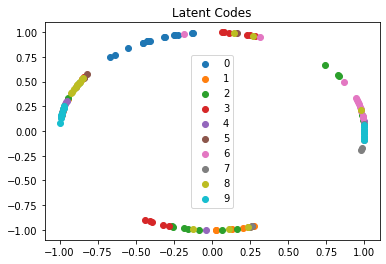

In [ ]:
display_latent_codes(norm_to_sphere_codes, labels)

So this norm to sphere thing to me seems like it improved how the codes are clustered. However, by forcing us to be on a sphere, we sacrifice a dimension in our latent space. If we were to have latent_dim=3 and norm_to_sphere=True, we can convert the 3d unit sphere codes into two dimensions with a bijection transformation depending on the angles $\phi$ and $\theta$ using sperical coordinates. We restrict $\rho=1$, so in terms of $x,y,z$, we have $\theta = arctan(y/x)$ and $\phi = arccos(z)$. 

In [ ]:
def convert_unit_sphere_codes(c):
  phi = np.arctan2(np.sqrt(c[:,0]**2+c[:,1]**2), c[:,2])
  theta = np.arctan2(c[:,1], c[:,0])
  return np.column_stack((theta, phi))

In [ ]:
norm_to_sphere_net2 = norm_to_sphere_net = train(regularize=False, norm_to_sphere=True, latent_dim=3)

Epoch: 0......Train Loss: 0.0596904415......Validation Loss:   0.048030.....Time: 7.02s
Epoch: 5......Train Loss: 0.0387358059......Validation Loss:   0.039604.....Time: 6.93s
Epoch: 10......Train Loss: 0.0365274697......Validation Loss:   0.037732.....Time: 6.92s
Epoch: 15......Train Loss: 0.0353623230......Validation Loss:   0.035559.....Time: 6.88s
Epoch: 20......Train Loss: 0.0351853092......Validation Loss:   0.035512.....Time: 6.78s
Epoch: 25......Train Loss: 0.0346188682......Validation Loss:   0.034685.....Time: 6.87s


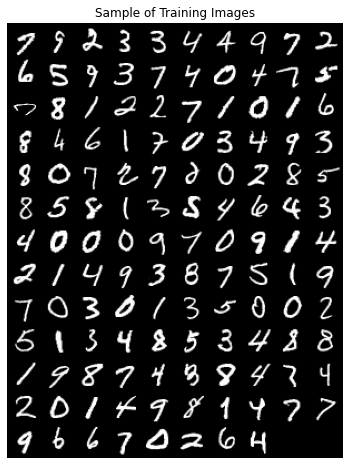

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


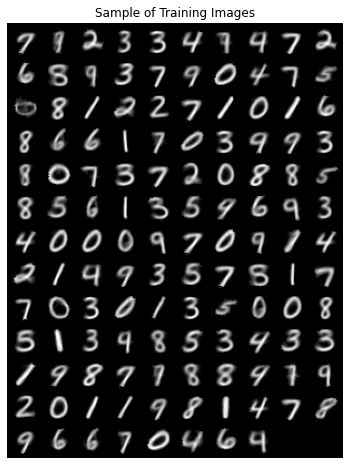

In [ ]:
norm_to_sphere2_codes, labels = display_model_results(norm_to_sphere_net)

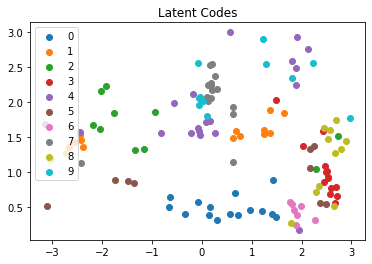

In [ ]:
two_d_codes = convert_unit_sphere_codes(norm_to_sphere2_codes)
display_latent_codes(two_d_codes, labels)

I feel like that's more clustered! I want to see more.

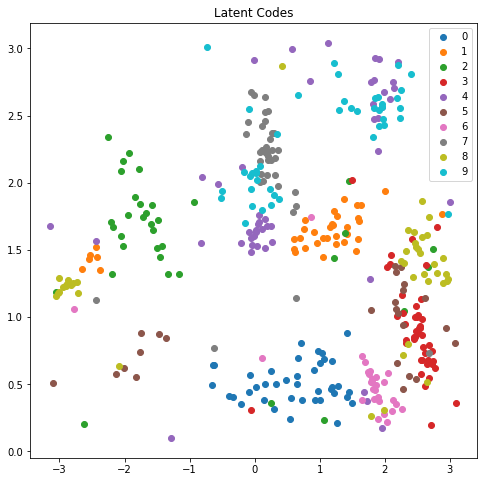

In [ ]:
codes2, labels2 = display_model_results(norm_to_sphere_net2, display=False)
codes3, labels3 = display_model_results(norm_to_sphere_net2, display=False)
codes = np.vstack((norm_to_sphere2_codes, codes2, codes3))
all_labels = torch.tensor(np.hstack((labels, labels2, labels3)))
plt.figure(figsize=(8,8))
display_latent_codes(convert_unit_sphere_codes(codes), all_labels)

# Experiments Pt 2

My goal is to incorporate more clustering in the latent space. I have a couple ideas for doing this:

  * Pairwise distances: We use torch.pdist and get subsets of batches indexed by their labels to regulate the size of intra-class latent codes. 
  * Regulating variance of clusters and inverse of distance between cluster center of masses. In theory, computing the variance is linear time while pairwise distance is quadratic. Also, this way we can encourage clusters to separate further, as well as optimize for tight clusters. 



In [ ]:
def train_clusters(epochs=31, norm_to_sphere=False, latent_dim=2):
  model = MNIST_AE(latent_dim=latent_dim, norm_to_sphere=norm_to_sphere)
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.MSELoss()

  for epoch in range(epochs):
    losses = []
    penalties = []
    start = time.time()
    for phase in ['train', 'test']:
      if phase == 'train':
        loader = train_loader
        model.train()
      else:
        loader = test_loader
        model.eval()
    
      running_loss = 0
      running_penalty = 0
      ctr = 0
      for x, y in loader:
        ctr += 1
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, z = model(x)
        loss = criterion(recon_x, x.view(-1, 784))
        # now we add the clustering penalties
        penalty = 0
        for l in range(10): # kind of cheating but whatever
          pdists = torch.pdist(z[y==l])
          penalty += torch.sum(pdists)
        loss += penalty
        running_penalty += penalty
        if phase == 'train':
          loss.backward()
          optimizer.step()

        running_loss += loss.item() * x.size(0)
      penalties.append(running_penalty / ctr)
      losses.append(running_loss / len(loader.dataset))

    if epoch % 5 == 0:
      print('Epoch: {:2}......Train Loss: {:.6f}......Validation Loss: {:.6f}.....Time: {:.2f}s'\
            .format(epoch, losses[0], losses[1], time.time()-start))
      print('Without cluster penalty...Train Loss: {:.6f}...Validation Loss: {:.6f}'\
            .format(losses[0]-penalties[0], losses[1]-penalties[1]))
      
  return model

In [ ]:
explicit_clusters_net = train_clusters()

Epoch:  0......Train Loss: 0.204262......Validation Loss: 0.082421.....Time: 9.18s
Without cluster penalty...Train Loss: 0.078681...Validation Loss: 0.079003
Epoch:  5......Train Loss: 0.077964......Validation Loss: 0.078439.....Time: 9.19s
Without cluster penalty...Train Loss: 0.077759...Validation Loss: 0.078261
Epoch: 10......Train Loss: 0.077327......Validation Loss: 0.077889.....Time: 9.20s
Without cluster penalty...Train Loss: 0.077294...Validation Loss: 0.077856
Epoch: 15......Train Loss: 0.077240......Validation Loss: 0.077896.....Time: 9.10s
Without cluster penalty...Train Loss: 0.077233...Validation Loss: 0.077885
Epoch: 20......Train Loss: 0.077102......Validation Loss: 0.077566.....Time: 9.05s
Without cluster penalty...Train Loss: 0.077100...Validation Loss: 0.077562
Epoch: 25......Train Loss: 0.076847......Validation Loss: 0.077462.....Time: 9.04s
Without cluster penalty...Train Loss: 0.076844...Validation Loss: 0.077459
Epoch: 30......Train Loss: 0.076822......Validation 

Yikes! Interesting, cluster penalty goes to 0, so I'm guessing that each class goes to a single latent code - or worse - everything goes to one point :(. Let's take a look.

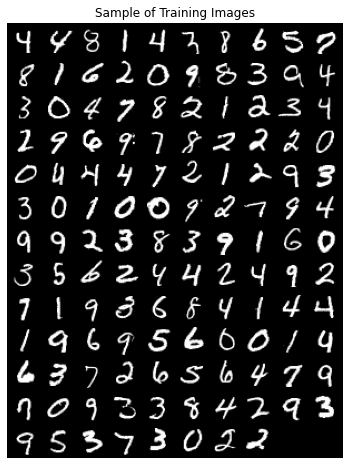

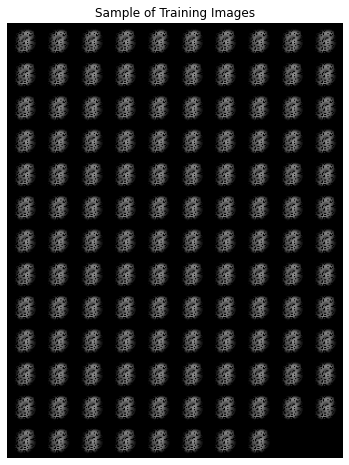

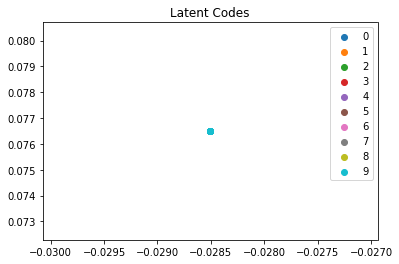

In [ ]:
c, l = display_model_results(explicit_clusters_net)
display_latent_codes(c,l)

It was indeed the latter! A failure mode that I probably could have predicted.

## Attempt 2

Let's try the running average idea. 

In [ ]:
def train_clusters2(epochs=31, norm_to_sphere=False, latent_dim=2):
  model = MNIST_AE(latent_dim=latent_dim, norm_to_sphere=norm_to_sphere)
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.MSELoss()

  for epoch in range(epochs):
    losses = []
    penalties = []
    start = time.time()
    for phase in ['train', 'test']:
      if phase == 'train':
        loader = train_loader
        model.train()
      else:
        loader = test_loader
        model.eval()
    
      running_loss = 0
      running_penalty = 0
      ctr = 0
      for x, y in loader:
        ctr += 1
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, z = model(x)
        loss = criterion(recon_x, x.view(-1, 784))
        # now we add the clustering penalties
        penalty = 0
        averages = []
        inter_cluster_dists = 0
        for l in range(10): # kind of cheating but whatever
          if np.isnan(torch.std(z[y==l]).detach().cpu()):
            pass
          averages.append(np.average(z[y==l].detach().cpu(), axis=0))
          penalty += torch.sum(torch.std(z[y==l], axis=0))
        cluster_to_cluster_dists = torch.sum(torch.pdist(torch.tensor(averages)))
        penalty += cluster_to_cluster_dists
        loss += penalty
        running_penalty += penalty
        if phase == 'train':
          loss.backward()
          optimizer.step()

        running_loss += loss.item() * x.size(0)
      penalties.append(running_penalty / ctr)
      losses.append(running_loss / len(loader.dataset))

    if epoch % 5 == 0:
      print('Epoch: {:2}......Train Loss: {:.6f}......Validation Loss: {:.6f}.....Time: {:.2f}s'\
            .format(epoch, losses[0], losses[1], time.time()-start))
      print('Without cluster penalty...Train Loss: {:.6f}...Validation Loss: {:.6f}'\
            .format(losses[0]-penalties[0], losses[1]-penalties[1]))
      
  return model

In [ ]:
clusters_net2 = train_clusters2(epochs=11)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Epoch:  0......Train Loss: 0.084587......Validation Loss: nan.....Time: 11.62s
Without cluster penalty...Train Loss: 0.078608...Validation Loss: nan
Epoch:  5......Train Loss: 686.576336......Validation Loss: nan.....Time: 11.46s
Without cluster penalty...Train Loss: -0.129944...Validation Loss: nan
Epoch: 10......Train Loss: nan......Validation Loss: nan.....Time: 11.48s
Without cluster penalty...Train Loss: nan...Validation Loss: nan


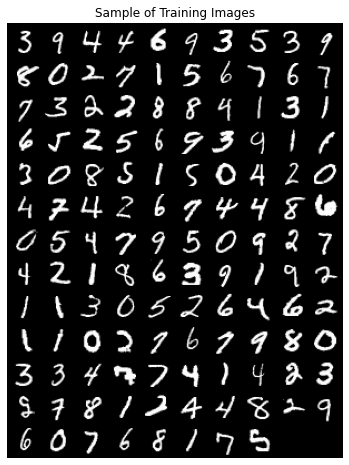

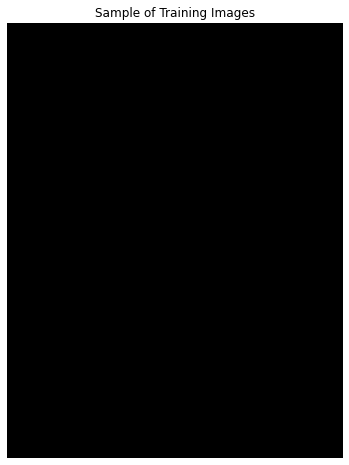

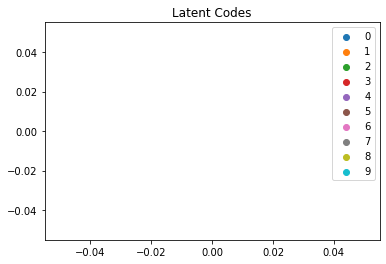

In [ ]:
c, l = display_model_results(clusters_net2)
display_latent_codes(c, l)

In [ ]:
tens = []
tens.append(torch.tensor([1,1,1]).numpy())
tens.append(torch.tensor([2,2,2]).numpy())
print(torch.tensor(tens))

tensor([[1, 1, 1],
        [2, 2, 2]])


In [ ]:
a = torch.tensor([[1,1,1],[1,2,3]]).float()
print(a)
print(np.average(a, axis=0))
print(a.mean(dim=0))
print(a-a.mean(dim=0))
print(torch.norm(a-a.mean(dim=0)))
print(a.std(dim=0))
print(2.5**0.5)

tensor([[1., 1., 1.],
        [1., 2., 3.]])
[1.  1.5 2. ]
tensor([1.0000, 1.5000, 2.0000])
tensor([[ 0.0000, -0.5000, -1.0000],
        [ 0.0000,  0.5000,  1.0000]])
tensor(1.5811)
tensor([0.0000, 0.7071, 1.4142])
1.5811388300841898


In [ ]:
tens = torch.tensor([[1,1],[1,4],[1,-1]]).float()
print(torch.pdist(tens))

tensor([3., 2., 5.])


In [ ]:
l = torch.LongTensor([1,0,1])
tens[l==1]

tensor([[ 1.,  1.],
        [ 1., -1.]])

In [ ]:
print(torch.pdist(torch.tensor(codes[labels==0])).shape)

torch.Size([66])
